In [97]:
# import libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential, model_from_json
from keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from matplotlib import rcParams
import h5py

In [73]:
cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "PedigreeFunction", "Age", "Outcome"]
df = pd.read_csv("pima-indians-diabetes.csv", names=cols)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,PedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [74]:
df.shape

(768, 9)

In [75]:
# Check for null values
df.isnull().sum()

Pregnancies         0
Glucose             0
BloodPressure       0
SkinThickness       0
Insulin             0
BMI                 0
PedigreeFunction    0
Age                 0
Outcome             0
dtype: int64

In [76]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,PedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


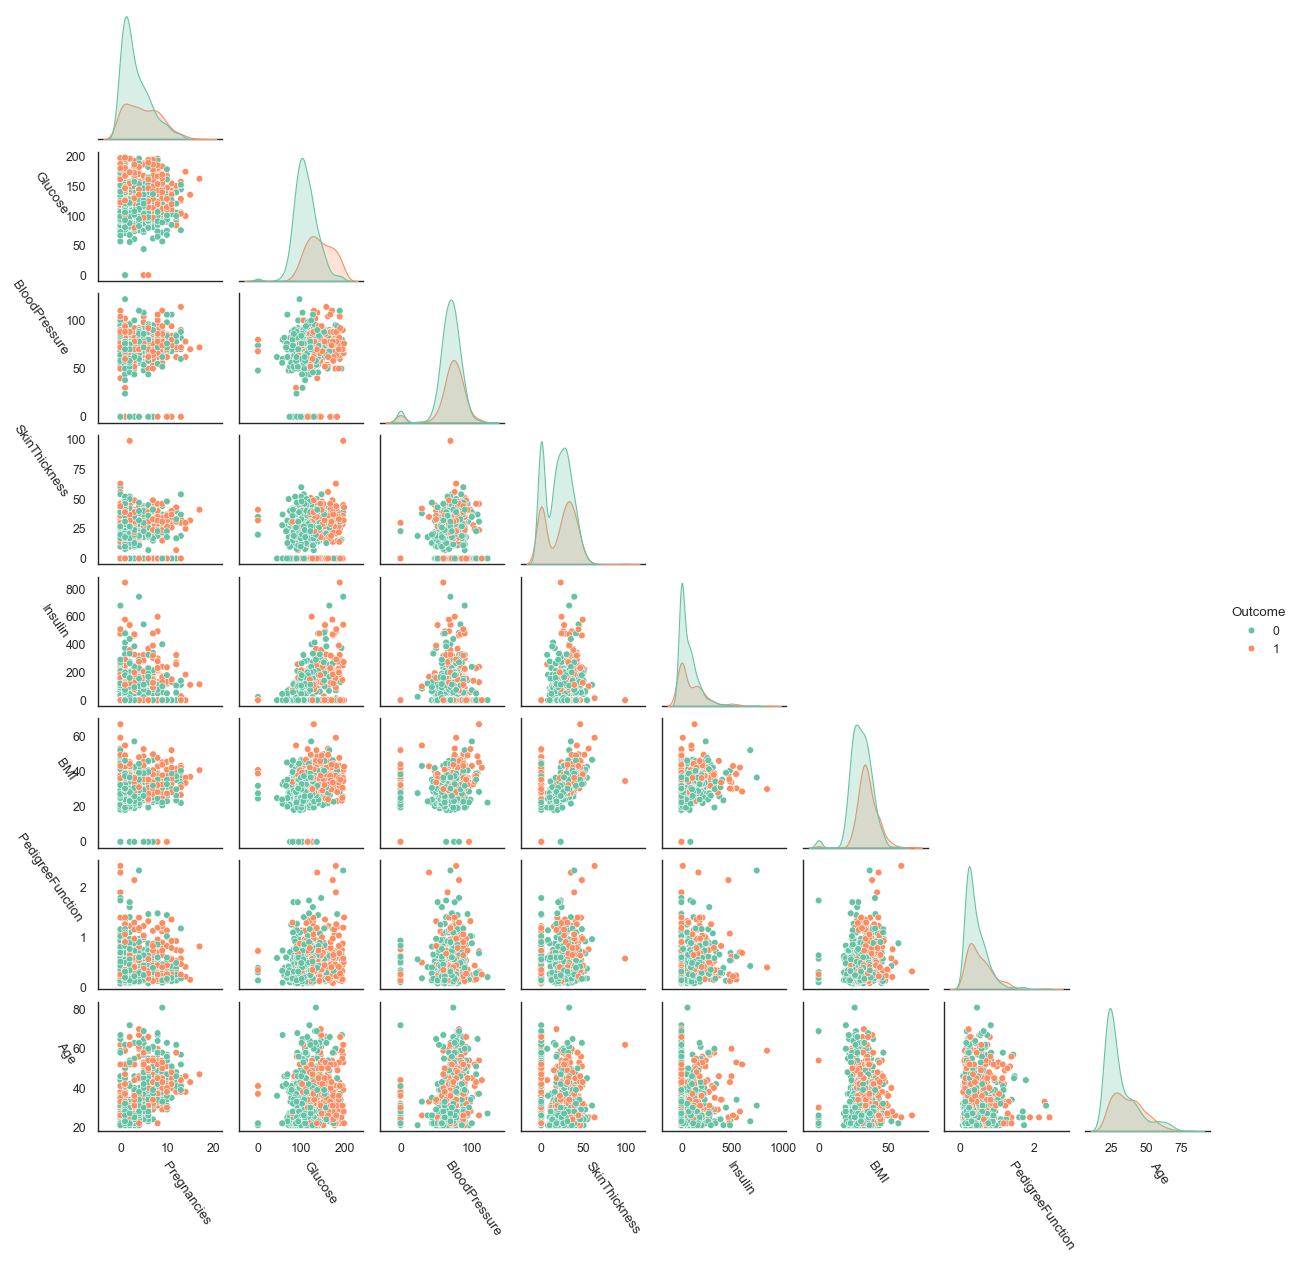

In [77]:
sns.set_context("paper", rc={"axes=labelsize":18})
plot = sns.pairplot(df, hue="Outcome", palette="Set2", corner=True, height=1.5)
for ax in plot.axes.flatten():
    if ax:
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation=-55, horizontalalignment="left")
        # rotate y axis labels
        ax.set_ylabel(ax.get_ylabel(), rotation= -55, horizontalalignment="right")

We can see that there are zero values for Glucose, BMI, BloodPressure, Insulin, and SkinThickness. Null values in the dataset were most likely replaced with 0s.

<Axes: >

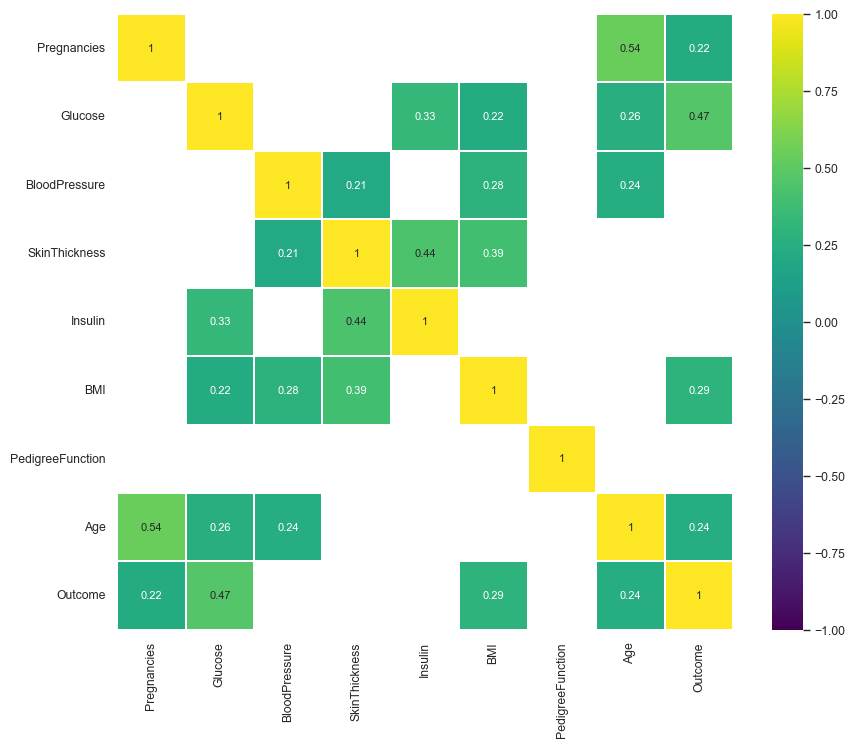

In [78]:
# Plot a correlation matrix 
corr = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr[(corr >= 0.2) | (corr <= -0.2)], cmap="viridis", vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size":8}, square=True)

In [79]:
# Find the missing values (0s) and replace with np.nan
df_copy = df.copy()
for c in ["BloodPressure", "BMI", "Glucose", "SkinThickness", "Insulin"]:
    df_copy[c].replace(to_replace=0, value=np.nan, inplace=True)
df_copy.isnull().sum()

Pregnancies           0
Glucose               5
BloodPressure        35
SkinThickness       227
Insulin             374
BMI                  11
PedigreeFunction      0
Age                   0
Outcome               0
dtype: int64

In [80]:
# Perform linear regression to replace 0s in Glucose
for metric in ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]:
    X = df[df[metric] != 0]
    X = X.drop(columns = [metric])
    y = df.loc[df[metric] != 0, metric]
    
    print("Training: ", metric, X.shape, y.shape)

    model = linear_model.LinearRegression()
    model.fit(X,y)
    X_miss = df[df[metric] == 0]
    X_miss = X_miss.drop(columns = [metric])
    print("Missing values: ", X_miss.shape)
    df.loc[df[metric] == 0, metric] == model.predict(X_miss)

Training:  Glucose (763, 8) (763,)
Missing values:  (5, 8)
Training:  BloodPressure (733, 8) (733,)
Missing values:  (35, 8)
Training:  SkinThickness (541, 8) (541,)
Missing values:  (227, 8)
Training:  Insulin (394, 8) (394,)
Missing values:  (374, 8)
Training:  BMI (757, 8) (757,)
Missing values:  (11, 8)


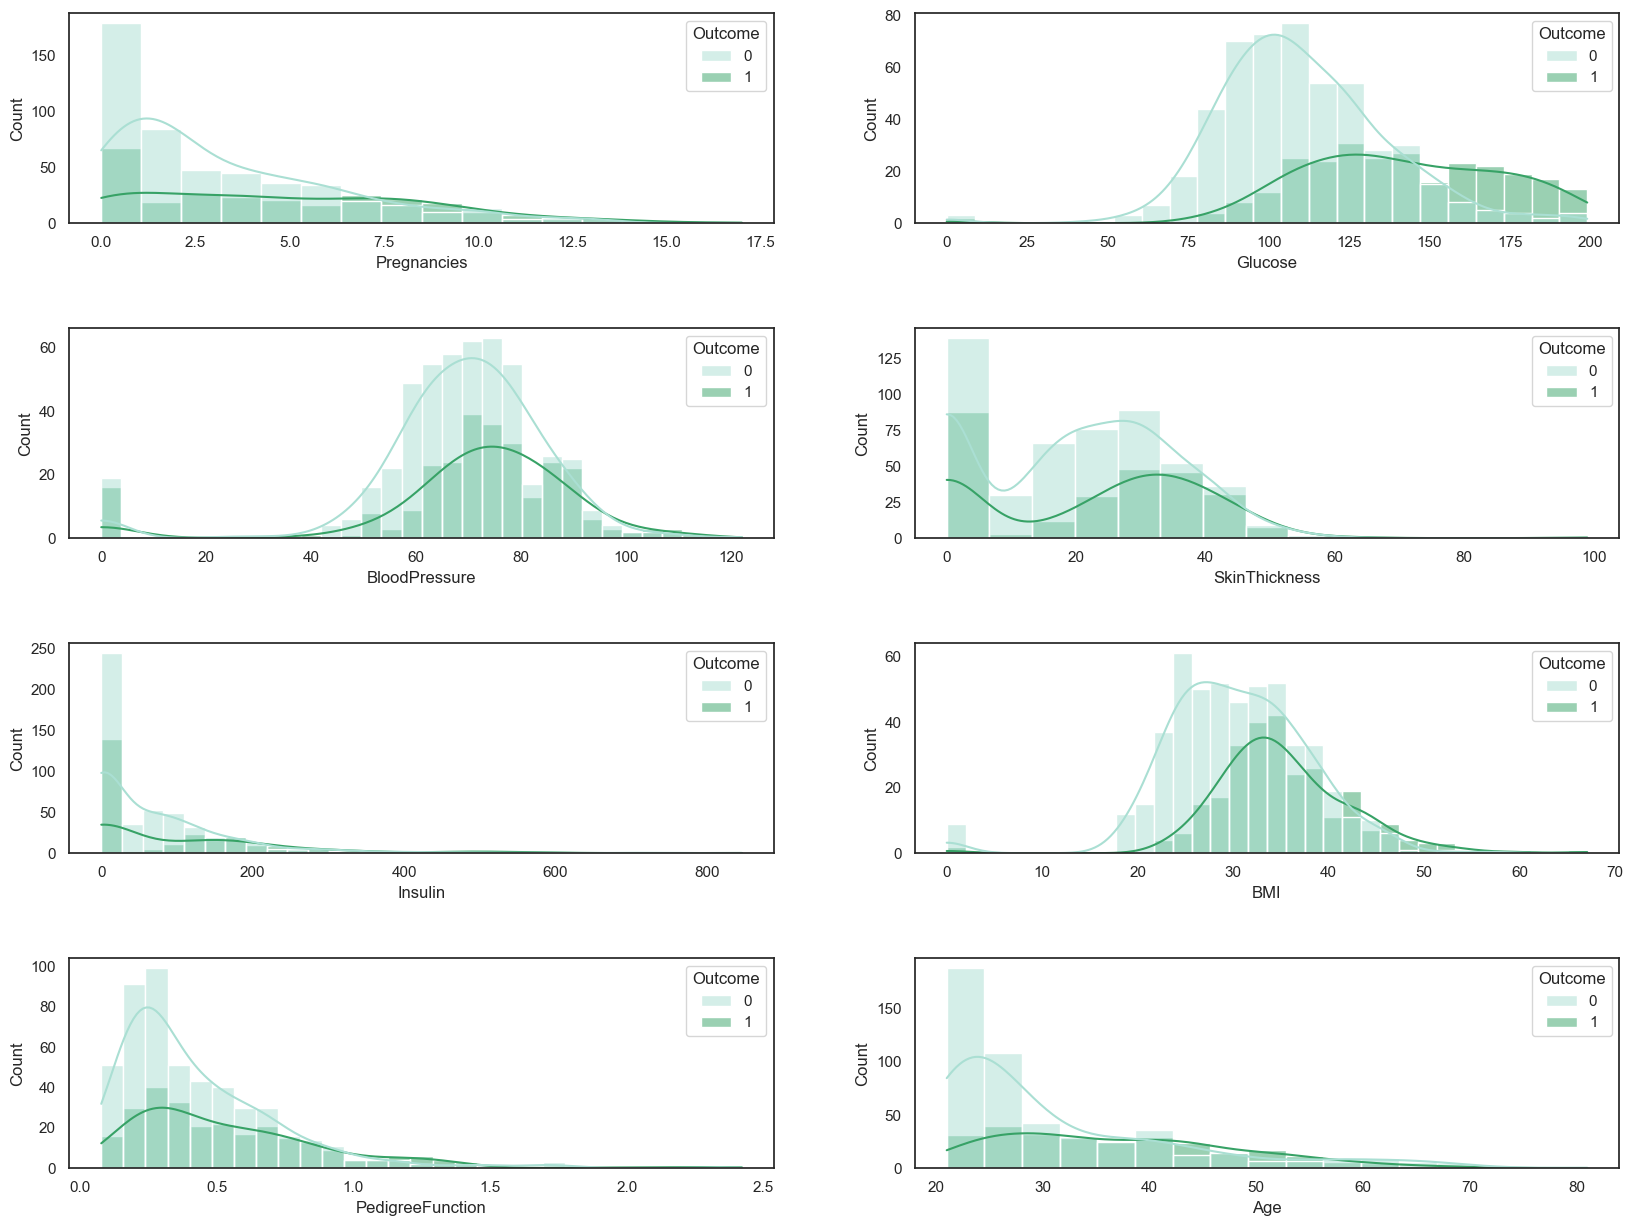

In [81]:
# Plot the features and normalize the positively skewed distributions 
columns = list(df.columns[:8])
rcParams["figure.figsize"] = 20,15
sns.set_theme(font_scale=1)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1
for feature in columns:
    plt.subplot(4,2,i)
    sns.histplot(data=df, x=feature, hue="Outcome", kde=True, palette="BuGn")
    i += 1

SkinThickness, Insulin, BMI, PedigreeFunction, and Age have positively skewed distributions need to be normalized

In [82]:
# Convert the columns to normal distributions using np.log
for col in ["SkinThickness", "Insulin", "BMI", "PedigreeFunction", "Age"]:
    df[col] = np.log(df[col])

/Users/bik/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


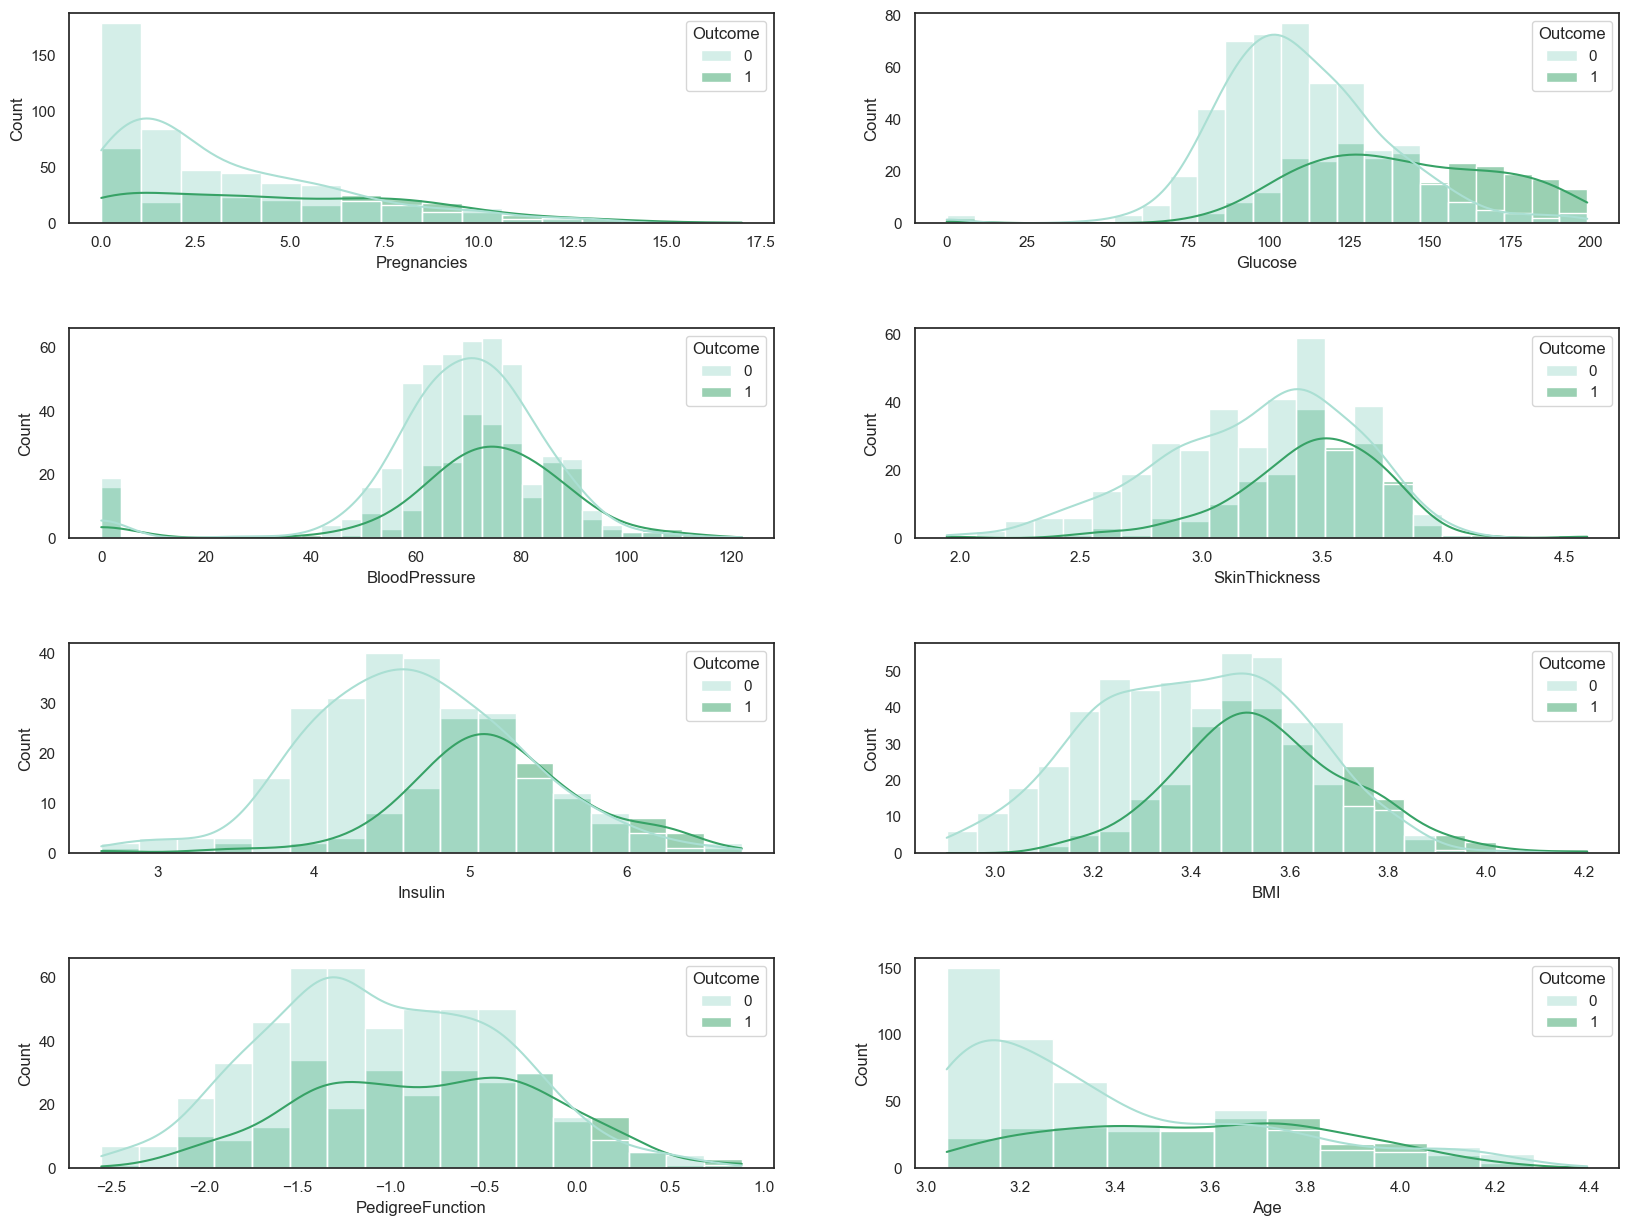

In [83]:
columns = list(df.columns[:8])
rcParams["figure.figsize"] = 20,15
sns.set_theme(font_scale=1)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1
for feature in columns:
    plt.subplot(4,2,i)
    sns.histplot(data=df, x=feature, hue="Outcome", kde=True, palette="BuGn")
    i += 1

In [84]:
# scale the data
df.replace([np.inf, -np.inf], 0, inplace=True)  
scaler = StandardScaler()
train_data = df.to_numpy()
train_data[:, :8] = scaler.fit_transform(train_data[:, :8])

In [85]:
train_data[:5, :]

array([[ 0.63994726,  0.84832379,  0.14964075,  0.79688671, -1.00487497,
         0.23076426,  0.76584846,  1.43637931,  1.        ],
       [-0.84488505, -1.12339636, -0.16054575,  0.6749312 , -1.00487497,
        -0.27523943, -0.13515874, -0.04593931,  0.        ],
       [ 1.23388019,  1.94372388, -0.26394125, -1.50882525, -1.00487497,
        -0.5621397 ,  0.87349186,  0.05250873,  1.        ],
       [-0.84488505, -0.99820778, -0.16054575,  0.52460337,  0.84601257,
        -0.15641765, -1.2887387 , -1.2536122 ,  0.        ],
       [-1.14185152,  0.5040552 , -1.50468724,  0.79688671,  1.08257072,
         0.77008513,  2.77622716,  0.14792711,  1.        ]])

Looking at the correlation matrix we can see that Pregnancies, Glucose, BMI, and Age have the highest correlations. So we'll use these features to predict diabetes.

In [86]:
# Extract features, split the data into train, validation, and test sets 
X = train_data[:, [0,1,5,7]]
Y = pd.get_dummies(train_data[:, 8])
X_train, X_assess, Y_train, Y_assess = train_test_split(X, Y, test_size=0.4, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_assess, Y_assess, test_size=0.5, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print("Y_train, Y_val, Y_test ", Y_train.shape, Y_val.shape, Y_test.shape)
print("X_train, X_val, X_test ", X_train.shape, X_val.shape, X_test.shape)

Y_train, Y_val, Y_test  (537, 2) (154, 2) (231, 2)
X_train, X_val, X_test  (537, 4) (154, 4) (231, 4)


In [101]:
# Initialize classifier 
def createModel(X_train, activation_type, output_activation, num_epochs, optimizer, loss_type):
    model = Sequential()
    # Input layer
    model.add(Dense(12, input_dim=X_train.shape[1], activation=activation_type))
    # Hidden Layer
    model.add(Dense(10,activation=activation_type))
    # Output Layer
    model.add(Dense(2, activation=output_activation))

    model.compile(optimizer=optimizer, loss=loss_type, metrics=["accuracy"])

    # stop training before overfitting occurs 
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto') 

    # save the best model
    checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True)

    model.fit(X_train, Y_train, epochs=num_epochs, validation_data=(X_val, Y_val), batch_size=32, verbose=1, callbacks=[monitor])
    
    scores = model.evaluate(X_test, Y_test)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))



In [93]:
createModel(X_train, "relu", "softmax", 100, "adam", "binary_crossentropy")

Epoch 1/100
17/17 [==============================] - 0s 5ms/step - loss: 0.7217 - accuracy: 0.3557 - val_loss: 0.7077 - val_accuracy: 0.3312
Epoch 2/100
17/17 [==============================] - 0s 1ms/step - loss: 0.7034 - accuracy: 0.4097 - val_loss: 0.6948 - val_accuracy: 0.4675
Epoch 3/100
17/17 [==============================] - 0s 1ms/step - loss: 0.6924 - accuracy: 0.5326 - val_loss: 0.6848 - val_accuracy: 0.6169
Epoch 4/100
17/17 [==============================] - 0s 1ms/step - loss: 0.6823 - accuracy: 0.6331 - val_loss: 0.6774 - val_accuracy: 0.6818
Epoch 5/100
17/17 [==============================] - 0s 1ms/step - loss: 0.6738 - accuracy: 0.6927 - val_loss: 0.6706 - val_accuracy: 0.7013
Epoch 6/100
17/17 [==============================] - 0s 1ms/step - loss: 0.6654 - accuracy: 0.7039 - val_loss: 0.6626 - val_accuracy: 0.7078
Epoch 7/100
17/17 [==============================] - 0s 1ms/step - loss: 0.6544 - accuracy: 0.7244 - val_loss: 0.6515 - val_accuracy: 0.7273
Epoch 8/100
1

We see that the model had an accuracy of 73.16%. We can improve on this by doing some hyperparameter tuning.

In [102]:
createModel(X_train, "tanh", "softmax", 250, "adam", "binary_crossentropy")

Epoch 1/250
17/17 [==============================] - 0s 5ms/step - loss: 0.6502 - accuracy: 0.6201 - val_loss: 0.6627 - val_accuracy: 0.5974
Epoch 2/250
17/17 [==============================] - 0s 1ms/step - loss: 0.5940 - accuracy: 0.7020 - val_loss: 0.6172 - val_accuracy: 0.6883
Epoch 3/250
17/17 [==============================] - 0s 1ms/step - loss: 0.5545 - accuracy: 0.7672 - val_loss: 0.5862 - val_accuracy: 0.7338
Epoch 4/250
17/17 [==============================] - 0s 1ms/step - loss: 0.5284 - accuracy: 0.7747 - val_loss: 0.5657 - val_accuracy: 0.7338
Epoch 5/250
17/17 [==============================] - 0s 1ms/step - loss: 0.5111 - accuracy: 0.7691 - val_loss: 0.5528 - val_accuracy: 0.7468
Epoch 6/250
17/17 [==============================] - 0s 1ms/step - loss: 0.4991 - accuracy: 0.7747 - val_loss: 0.5427 - val_accuracy: 0.7468
Epoch 7/250
17/17 [==============================] - 0s 1ms/step - loss: 0.4900 - accuracy: 0.7784 - val_loss: 0.5371 - val_accuracy: 0.7532
Epoch 8/250
1

In [117]:
# Initialize classifier 
model = Sequential()
# Input layer
model.add(Dense(12, input_dim=X_train.shape[1], activation="tanh"))
# Hidden Layers
model.add(Dense(6,activation="tanh"))
# Output Layer
model.add(Dense(2, activation="softmax"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# stop training before overfitting occurs 
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto') 

# save the best model
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True)

model.fit(X_train, Y_train, epochs=100, validation_data=(X_val, Y_val), batch_size=16, verbose=1, callbacks=[monitor])


Epoch 1/100
34/34 [==============================] - 0s 3ms/step - loss: 0.7561 - accuracy: 0.3743 - val_loss: 0.7242 - val_accuracy: 0.4805
Epoch 2/100
34/34 [==============================] - 0s 887us/step - loss: 0.6792 - accuracy: 0.6387 - val_loss: 0.6600 - val_accuracy: 0.6494
Epoch 3/100
34/34 [==============================] - 0s 854us/step - loss: 0.6263 - accuracy: 0.7244 - val_loss: 0.6153 - val_accuracy: 0.6948
Epoch 4/100
34/34 [==============================] - 0s 817us/step - loss: 0.5880 - accuracy: 0.7374 - val_loss: 0.5824 - val_accuracy: 0.7532
Epoch 5/100
34/34 [==============================] - 0s 809us/step - loss: 0.5586 - accuracy: 0.7467 - val_loss: 0.5570 - val_accuracy: 0.7403
Epoch 6/100
34/34 [==============================] - 0s 796us/step - loss: 0.5361 - accuracy: 0.7486 - val_loss: 0.5367 - val_accuracy: 0.7403
Epoch 7/100
34/34 [==============================] - 0s 780us/step - loss: 0.5182 - accuracy: 0.7598 - val_loss: 0.5226 - val_accuracy: 0.7403
E

In [118]:
scores = model.evaluate(X_test, Y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

8/8 [==============================] - 0s 634us/step - loss: 0.5381 - accuracy: 0.7316
accuracy: 73.16%


In [119]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [120]:
actuals = np.argmax([Y_test.T], axis=1)[0]
Y_predicted = model.predict(X_test)
classes = np.argmax(Y_predicted, axis=1)

8/8 [==============================] - 1s 447us/step


Text(17.25, 0.5, 'True')

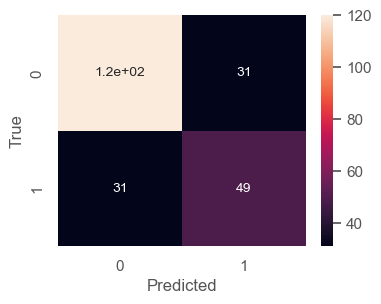

In [121]:
cm = confusion_matrix(actuals, classes)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

In [122]:
target_names = ["diabetes", "no-diabetes"]
print(classification_report(actuals, classes, target_names=target_names))

              precision    recall  f1-score   support

    diabetes       0.79      0.79      0.79       151
 no-diabetes       0.61      0.61      0.61        80

    accuracy                           0.73       231
   macro avg       0.70      0.70      0.70       231
weighted avg       0.73      0.73      0.73       231

